In [11]:
import pandas as pd
import MyLib.nlp as nlp
import MyLib.HTML_prep as HTML_prep
import MyLib.analysis as analysis 
import MyLib.hype as hype 
from ipywidgets import interactive, interact

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Import Files & group by date


In [85]:
freq="M"
df=pd.read_json("2023-06-06_Zotero_AI_nlp_en2.json")
print("total:", len(df))

df_publ=df.drop_duplicates(subset="FileKey")[["date","FileKey"]]
df_publ=df_publ.set_index("date").groupby(pd.Grouper(freq=freq)).count()
df_publ.columns=["publications"]
df_publ.tail()

total: 1622


,publications
date,
2023-02-28,27
2023-03-31,39
2023-04-30,45
2023-05-31,52
2023-06-30,17


# 2. Most common words

In [110]:
# ChatGPT_Terms="ChatGPT, GPT3, GPT4, OpenAI, AI, LLM, A.I, GPT, Chatbot, technology, tool, app, Artificial Intelligence, Large Language Models"


In [3]:
df["NoStopwords_Set"]=df.NoStopwords.apply(lambda x: list(x))
Lists=df.NoStopwords_Set.to_list()


[('ai', 2642), ('chatgpt', 1762), ('chatbot', 1611), ('human', 975), ('work', 963), ('research', 922), ('student', 870), ('use', 852), ('datum', 787), ('university', 713), ('system', 676), ('information', 665), ('technology', 605), ('example', 558), ('new', 553)]


<AxesSubplot: ylabel='word'>

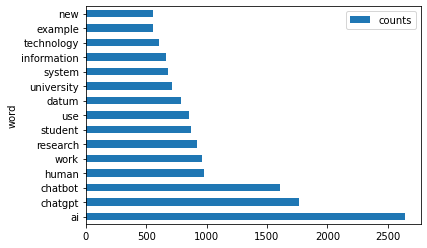

In [4]:
Lists=df.NoStopwords.to_list()

Lists=[i for i in Lists if i!=None]
Words=[item for sublist in Lists for item in sublist]

from collections import Counter
a_counter = Counter(Words)
most_common = a_counter.most_common(15)

print(most_common)#, most_common2)
pd.DataFrame.from_records(most_common,columns=["word","counts"],index="word").plot.barh()

# Finding the most hyping universities, articles, and sentences

In [20]:
from nltk.tokenize import sent_tokenize

#Find sentences

df["AI_sentences"]=df.AI_paragraphs.apply(sent_tokenize)
df=df.explode("AI_sentences").drop_duplicates(subset=["AI_sentences"]).dropna(subset=["AI_sentences"]).reset_index()


In [112]:
# Redo the NLP for AI Sentences as the DF structure changed (explode)

df_Sentences=nlp.NLP_Pipeline(df, sentiment=False, language="en",translate=False, column="AI_sentences")

Current Time = 12:21:28
Lenght:  5807
cleaning done.
Current Time = 12:21:30
Current Time = 12:22:26
language detection done.
pure english text done. Next: Token & Lemmatizing.
Current Time = 12:22:26
Token & Lemmatizing done. Next: Remove Stopwords.
Current Time = 12:24:03
Current Time = 12:24:03


In [114]:
df_Sentences.to_json("2023-06-14_HypeSentences.json")

In [88]:
df=pd.read_json("2023-06-14_HypeSentences.json")

df.head()
#df_test["NER"]=df_test.AI_sentences.apply(NER)

,index,Uni,FileKey,url,date,Title,linkName,linkUrl,AI_paragraphs,text_clean,letters_count,word_count,language,source_language,pure_text,Lemmata,NoStopwords,AI_sentences
0,0,Radboud Nijmegen,QJ4WZUBB,https://www.ru.nl/communicationscience/researc...,2023-01-01,Research projects - Communication Science,"[More information., Information Explosion, INt...",[https://www.ru.nl/communicationscience/@96084...,INtoEAT: Chatbot algorithms and coaching strat...,INtoEAT: Chatbot algorithms and coaching strat...,69,9,en,en,intoeat chatbot algorithms and coaching strate...,"[intoeat, chatbot, algorithm, and, coach, stra...","[intoeat, chatbot, algorithm, coach, strategy,...",INtoEAT: Chatbot algorithms and coaching strat...
1,1,Radboud Nijmegen,QJ4WZUBB,https://www.ru.nl/communicationscience/researc...,2023-01-01,Research projects - Communication Science,"[More information., Information Explosion, INt...",[https://www.ru.nl/communicationscience/@96084...,Chatbot Usability - Studying the Impact of Cha...,Chatbot Usability - Studying the Impact of Cha...,106,16,en,en,chatbot usability studying the impact of chat...,"[chatbot, usability, study, the, impact, of, c...","[chatbot, usability, study, impact, chatbot, b...",Chatbot Usability - Studying the Impact of Cha...
2,2,Radboud Nijmegen,K3P5X7U4,https://www.ru.nl/communicatiewetenschap/onder...,2023-01-01,INtoEAT: Chatbot algorithms and coaching strat...,[],[],INtoEAT: Chatbot algorithms and coaching strat...,INtoEAT: Chatbot algorithms and coaching strat...,94,11,en,en,intoeat chatbot algorithms and coaching strate...,"[intoeat, chatbot, algorithm, and, coach, stra...","[intoeat, chatbot, algorithm, coach, strategy,...",INtoEAT: Chatbot algorithms and coaching strat...
3,3,Radboud Nijmegen,K3P5X7U4,https://www.ru.nl/communicatiewetenschap/onder...,2023-01-01,INtoEAT: Chatbot algorithms and coaching strat...,[],[],A healthy diet can help keep the body and mind...,A healthy diet can help keep the body and mind...,86,17,en,en,a healthy diet can help keep the body and mind...,"[a, healthy, diet, can, help, keep, the, body,...","[healthy, diet, help, body, mind, healthy, ext...",A healthy diet can help keep the body and mind...
4,3,Radboud Nijmegen,K3P5X7U4,https://www.ru.nl/communicatiewetenschap/onder...,2023-01-01,INtoEAT: Chatbot algorithms and coaching strat...,[],[],A healthy diet can help keep the body and mind...,A healthy diet and lifestyle are even more imp...,88,15,en,en,a healthy diet and lifestyle are even more imp...,"[a, healthy, diet, and, lifestyle, be, even, m...","[healthy, diet, lifestyle, important, elderly,...",A healthy diet and lifestyle are even more imp...


In [110]:
# 1. Select Wordlist: here - from my hype library module (see Miller et al.)

WordLists=["predictive","imperative","subjunctive","hype_words","mod_words"] # Load from the hype module.

for wordList in WordLists:
    wordlist=hype.WordListDict[wordList]
    df[wordList+"_word"]=df.AI_sentences.apply(hype.hype_word,keys=wordlist)
    df[wordList+"_sentence"]=df.AI_sentences.apply(hype.hype_sentence,keys=wordlist)
    df[wordList+"_n"]=df[wordList+"_word"].apply(lambda x: len(x) if isinstance(x,list) else 0)
    
    print(f"\n ---> {wordList} <--- \n")
    
    example=df.sort_values(wordList+"_n", ascending=False).head()
    example[[wordList+"_word",wordList+"_n"]]
    
    for i in example[wordList+"_sentence"]:
        print(i)


    

df.head()

mod_words=df[df['mod_words_n']>0]




 ---> predictive <--- 

["Of course, you are also free to shape this outside this meeting.During the meeting, you will be asked to share briefly how you are already working on Artificial Intelligence in education, and/or how you would like to contribute to a project.If you would like to contribute as a consortium member or leader, but cannot attend the meeting, you may send a message to cat@uu.nl stating 'USO- Artificial Intelligence in Education', indicating how you would like to contribute to a project (as a consortium member, or leader; what activities would you like to contribute in the project?)."]
['For this reason, it is important to maintain our ability to critically examine information and engage in independent thinking, so that we can step in when required and make informed decisions based on our unique understanding of the situation.What to be mindful about and what’s next?As advanced chatbots may continue to substitute more and more the independent human thought process, t

C:\Users\mr\AppData\Local\Temp\ipykernel_14624\2023392683.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  timerows[["publications","hype_words","mod_words"]][timerows.index>pd.datetime(2022,6,1)].plot()
C:\Users\mr\AppData\Local\Temp\ipykernel_14624\2023392683.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  timerows[["publications","predictive","imperative","subjunctive"]][timerows.index>pd.datetime(2022,6,1)].plot()


<AxesSubplot: xlabel='date'>

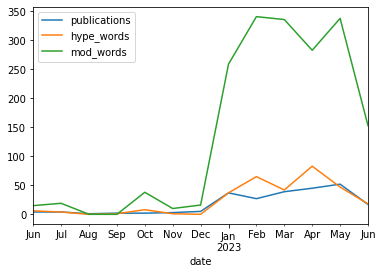

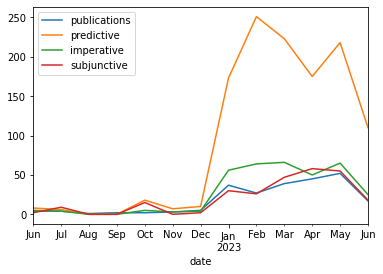

In [93]:
## Generate Timerows

freq="M"

hype_time=df.set_index("date").groupby(pd.Grouper(freq=freq))

timerows=df_publ
for l in WordLists:
    timerows[l]=hype_time[l+"_n"].apply(lambda x: sum(x) if len(x)>0 else 0)
    
timerows[["publications","hype_words","mod_words"]][timerows.index>pd.datetime(2022,6,1)].plot()
timerows[["publications","predictive","imperative","subjunctive"]][timerows.index>pd.datetime(2022,6,1)].plot()

# Named entity recognition of hype sentences

In [31]:
df_test=df[df.language=="en"].explode(column="hype_sentence")[:20]

def NER(RAW_text):
    import spacy
    from spacy import displacy

    NER = spacy.load("en_core_web_sm")
    text=NER(RAW_text)

    text=[(word.text, word.label_) for word in text.ents]
    
    return text


df_test["NER"]=df_test.AI_sentences.apply(NER)
df_test["NER"]

2591                                                   []
2358    [(centre?One, CARDINAL), (the EUR Smart Campus...
2659    [(One, CARDINAL), (three, CARDINAL), (just fou...
50                                                     []
467                                           [(AI, ORG)]
2785                                                   []
2374                    [(recent years, DATE), (AI, ORG)]
230                                                    []
1447                                                   []
4153                                  [(Vincent, PERSON)]
2376                    [(AI, ORG), (AI, ORG), (AI, ORG)]
4177                                  [(Vincent, PERSON)]
5591                                                   []
3163                    [(ChatLab, ORG), (two, CARDINAL)]
2683    [(EUR, ORG), (AI, ORG), (ERS Business Developm...
3127                    [(ChatLab, ORG), (two, CARDINAL)]
2409                    [(recent years, DATE), (AI, ORG)]
3474    [(Chat

In [32]:
pd.set_option('display.max_colwidth', None)
[i for i in df_test["NER"]]

[[],
 [('centre?One', 'CARDINAL'),
  ('the EUR Smart Campus Project', 'ORG'),
  ('Opens', 'ORG')],
 [('One', 'CARDINAL'),
  ('three', 'CARDINAL'),
  ('just four days', 'DATE'),
  ('5', 'CARDINAL'),
  ('European', 'NORP'),
  ('EUR', 'ORG'),
  ('TU Delft', 'ORG'),
  ('Zuid', 'GPE'),
  ('Holland', 'GPE'),
  ('NWO', 'ORG'),
  ('EUR', 'ORG'),
  ('first', 'ORDINAL'),
  ('2', 'CARDINAL')],
 [],
 [('AI', 'ORG')],
 [],
 [('recent years', 'DATE'), ('AI', 'ORG')],
 [],
 [],
 [('Vincent', 'PERSON')],
 [('AI', 'ORG'), ('AI', 'ORG'), ('AI', 'ORG')],
 [('Vincent', 'PERSON')],
 [],
 [('ChatLab', 'ORG'), ('two', 'CARDINAL')],
 [('EUR', 'ORG'),
  ('AI', 'ORG'),
  ('ERS Business Development & Knowledge Transfer Team', 'ORG')],
 [('ChatLab', 'ORG'), ('two', 'CARDINAL')],
 [('recent years', 'DATE'), ('AI', 'ORG')],
 [('ChatGPT', 'ORG'), ('Google', 'ORG'), ('one', 'CARDINAL'), ('AI', 'ORG')],
 [('the Centre of Expertise in Learning & Teaching', 'ORG'),
  ('one', 'CARDINAL'),
  ('AI', 'ORG'),
  ('AI', 'ORG')

# Hype-word statistics per university

In [68]:
Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="FileKey").value_counts("Uni"), 
                     "sentences":df.value_counts("Uni"),
                    "mod_words":df.groupby("Uni").sum()["mod_words_n"]})

Counts["mean mod-words"]=Counts["mod_words"]/Counts["sentences"]

Counts.sort_values("mean mod-words", ascending=False)

,publications,sentences,mod_words,mean mod-words
Uni,,,,
Rotterdam University,29,493,298,0.604462
Utrecht University,32,955,481,0.503665
University of Groningen,15,184,84,0.456522
Vrije Universiteit Amsterdam,26,655,294,0.448855
University of Twente,23,244,104,0.426230
Maastricht Univerisity,26,494,208,0.421053
University of Amsterdam,24,304,126,0.414474
Wageningen University,9,222,92,0.414414
Leiden University,40,428,144,0.336449


In [69]:
Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="FileKey").value_counts("Uni"), 
                     "sentences":df.value_counts("Uni"),
                    "hype_words":df.groupby("Uni").sum()["hype_words_n"]})

Counts["mean hype_words"]=Counts["hype_words"]/Counts["sentences"]
Counts.sort_values("mean hype_words", ascending=False)

,publications,sentences,hype_words,mean hype_words
Uni,,,,
Rotterdam University,29,493,82,0.166329
Vrije Universiteit Amsterdam,26,655,70,0.106870
University of Twente,23,244,26,0.106557
University of Amsterdam,24,304,29,0.095395
Maastricht Univerisity,26,494,36,0.072874
Wageningen University,9,222,15,0.067568
Utrecht University,32,955,62,0.064921
Tilburg University,12,234,13,0.055556
Radboud Nijmegen,28,374,19,0.050802


# Check hype sentences

In [34]:
pd.options.display.max_colwidth = 500
hype_sentences=df.iloc[:12,-4:]
hype_sentences
hype_sentences.to_excel("hype_sentences.xlsx")

In [40]:
hype_sentences=df[['Uni','date',"hype_n","AI_sentences",'word_count','hype_word']]
#hype_sentences["hype_ratio"]=hype_sentences["hype_n"]/hype_sentences["word_count"]
#hype_sentences.drop_duplicates(subset="AI_sentences")
hype_sentences.sort_values(by="hype_n", ascending=False).head(10)

,Uni,date,hype_n,AI_sentences,word_count,hype_word
2358,Rotterdam University,2023-04-25,3,Can you discuss any particularly innovative or...,712,"[notable, innovative, particularly]"
2591,Rotterdam University,2022-05-24,3,This shift has offered the opportunity to expa...,72,"[important, novel, effectively]"
230,Radboud Nijmegen,2023-04-01,2,Will ChatGPT fundamentally change our educatio...,60,"[fundamentally, fundamental]"
3428,Vrije Universiteit Amsterdam,2023-02-10,2,It will significantly change many aspects of o...,150,"[significant, significantly]"
3474,Vrije Universiteit Amsterdam,2023-02-24,2,ChatGPT's sophisticated features therefore ope...,728,"[essential, disrupt]"
3581,Vrije Universiteit Amsterdam,2023-02-24,2,This creates a double risk: not only may human...,755,"[essential, especially]"
4885,Maastricht Univerisity,2023-01-30,2,The most notable of these disruptions came fro...,61,"[notable, disrupt]"
309,Radboud Nijmegen,2023-04-26,2,By exploring how AI can complement and enhance...,56,"[effectively, empower]"
3513,Vrije Universiteit Amsterdam,2023-02-24,2,This creates a double risk: not only may human...,757,"[essential, especially]"
1236,University of Twente,2023-06-05,2,To help you see the potential risk in your typ...,304,"[relevant, especially]"


In [37]:
df.columns

Index(['index', 'Uni', 'FileKey', 'url', 'date', 'Title', 'linkName',
       'linkUrl', 'AI_paragraphs', 'text_clean', 'letters_count', 'word_count',
       'language', 'source_language', 'pure_text', 'Lemmata', 'NoStopwords',
       'NoStopwords_Set', 'AI_sentences', 'hype_word', 'hype_sentence',
       'modal_word', 'modal_sentence', 'modal_n', 'hype_n'],
      dtype='object')

In [70]:



mod_df=pd.DataFrame({"mod_words":hype_time["mod_words_n"].apply(lambda x: sum(x) if len(x)>0 else 0)})
hype_df=pd.DataFrame({"hype_words":hype_time["hype_words_n"].apply(lambda x: sum(x) if len(x)>0 else 0)})




C:\Users\mr\AppData\Local\Temp\ipykernel_14624\594162809.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  hype_df[hype_df.index>pd.datetime(2022,6,1)]["hype_words"].plot(title=f"n_hypewords peer {freq}",legend=True)
C:\Users\mr\AppData\Local\Temp\ipykernel_14624\594162809.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df_publ[df_publ.index>pd.datetime(2022,6,1)]["Publications"].plot(legend=True)
C:\Users\mr\AppData\Local\Temp\ipykernel_14624\594162809.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  mod_df[modal_df.index>pd.datetime(2022,6,1)]["mod_words"].plot(title=f"n_modal_words peer {freq}",legend=True, secondary_y=True)


<AxesSubplot: >

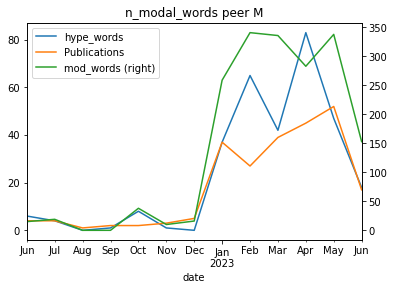

In [73]:
hype_df[hype_df.index>pd.datetime(2022,6,1)]["hype_words"].plot(title=f"n_hypewords peer {freq}",legend=True)
df_publ[df_publ.index>pd.datetime(2022,6,1)]["Publications"].plot(legend=True)
mod_df[modal_df.index>pd.datetime(2022,6,1)]["mod_words"].plot(title=f"n_modal_words peer {freq}",legend=True, secondary_y=True)

C:\Users\mr\AppData\Local\Temp\ipykernel_14624\1001894237.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  timerows[["predictive","imperative","subjunctive"]][timerows.index>pd.datetime(2022,6,1)].plot()


<AxesSubplot: xlabel='date'>

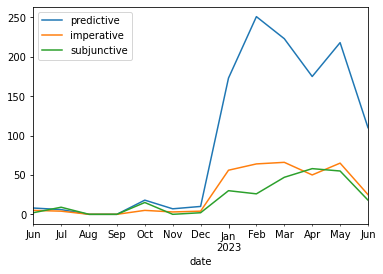

In [37]:
hype_time=hype_sentences.set_index("date").groupby(pd.Grouper(freq='W'))
hype_time

# Use of words over time

In [38]:
from collections import Counter


keyWords="chatgpt,education,chatbot,university,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"
keyWords="education,chatbot,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"

keyWords=keyWords.split(",")
print(keyWords)

group=df.set_index("date").groupby(pd.Grouper(freq='M'))["NoStopwords"].sum()

Wordyear={}
Wordyear_exact={}
Wordyear_only={}
for i, row in group.iteritems():
    
    #print(i,row)
    if type(row)==list:
        
        ## filter ROW for interesting key-words:
        row=[i for i in row if i in keyWords]
        
        c=Counter(row).most_common(5)
        
        c_exact=[(i[0],i[1]/len(group)) for i in c]

        c=[(i[0],str(round(i[1]/len(group)*100,2))+"%") for i in c]
        c_only=[i[0] for i in c]


        Wordyear[str(i)]=c
        Wordyear_exact[str(i)]=c_exact
        Wordyear_only[str(i)]=c_only
        
        
        
    #print(c,"\n")
    
CountDF=pd.DataFrame.from_dict(Wordyear, orient='index').T


CountDF.T[CountDF.T.index>"2022-10-01"]

['education', 'chatbot', 'create', 'write', 'produce', 'answer', 'tool', 'human', 'skill', 'knowledge', 'bias', 'assignment', 'intelligence', 'artificial', 'test', 'evaluate', 'assessment', 'plagiarism']


,0,1,2,3,4
2022-10-31 00:00:00,"(knowledge, 79.93%)","(artificial, 31.29%)","(intelligence, 31.29%)","(create, 11.9%)","(chatbot, 8.16%)"
2022-11-30 00:00:00,"(chatbot, 12.59%)",None,None,None,None
2022-12-31 00:00:00,"(write, 36.39%)","(answer, 16.67%)","(human, 10.88%)","(artificial, 7.82%)","(intelligence, 7.82%)"
2023-01-31 00:00:00,"(write, 113.27%)","(tool, 111.22%)","(answer, 102.72%)","(chatbot, 100.34%)","(human, 94.22%)"
2023-02-28 00:00:00,"(chatbot, 607.82%)","(human, 521.43%)","(write, 228.23%)","(knowledge, 148.64%)","(skill, 124.15%)"
2023-03-31 00:00:00,"(answer, 471.09%)","(chatbot, 399.32%)","(write, 327.55%)","(create, 182.99%)","(tool, 176.19%)"
2023-04-30 00:00:00,"(human, 151.7%)","(create, 149.66%)","(education, 141.84%)","(knowledge, 126.87%)","(intelligence, 72.45%)"
2023-05-31 00:00:00,"(education, 185.03%)","(intelligence, 177.55%)","(artificial, 171.77%)","(chatbot, 156.8%)","(write, 131.63%)"
2023-06-30 00:00:00,"(intelligence, 159.18%)","(artificial, 124.49%)","(education, 84.35%)","(human, 78.23%)","(write, 54.08%)"


In [53]:
CountDF=pd.DataFrame.from_dict(Wordyear_only, orient='index').T
CountDF.T[CountDF.T.index>"2022-10-01"]

,0,1,2,3,4
2022-10-31 00:00:00,knowledge,artificial,intelligence,create,chatbot
2022-11-30 00:00:00,chatbot,None,None,None,None
2022-12-31 00:00:00,write,answer,human,skill,artificial
2023-01-31 00:00:00,write,tool,answer,chatbot,human
2023-02-28 00:00:00,chatbot,human,write,knowledge,skill
2023-03-31 00:00:00,answer,chatbot,write,create,tool
2023-04-30 00:00:00,human,create,education,knowledge,intelligence
2023-05-31 00:00:00,education,intelligence,artificial,chatbot,write
2023-06-30 00:00:00,intelligence,artificial,education,human,write


In [54]:
#df=df.drop_duplicates("text_clean")

# Words in context & Word-Graph analysis

In [116]:
#This cell allows to read the words before and after a search_word. You can change the searchword & the size of the context.
@interact(search_word="education",words_before=(0,10),words_after=(0,10))
def text_context(column=["text_clean","pure_text","NoStopwords","AI_sentences"],search_word="education",words_before=1,words_after=1):
    df_Sentences[column].dropna().apply(analysis.Keyword_context,search_word=search_word.lower(),context=(words_before,words_after))


interactive(children=(Dropdown(description='column', options=('text_clean', 'pure_text', 'NoStopwords', 'AI_se…

In [126]:
# WORD _GRAPH ANALYSIS

G=analysis.Word_NetworkGen(df_Sentences,n=500,column="NoStopwords")
G2=analysis.CleanGraph(G,removeIsolates=True,minDegree=2,only_largest_component=True)
#G2=G
analysis.writeNetworkHTML(G2,view=False)
print("see the network: The_network.html")

[(('topic', 'research'), 335), (('ai', 'ai'), 316), (('list', 'research'), 282), (('topic', 'topic'), 259), (('university', 'university'), 255)]
Cleaning Graph to minimum Degree 2.
Nodes count:  85
Edges count:  357
see the network: The_network.html


In [128]:
Centrality=pd.DataFrame(nx.closeness_centrality(G), index=[0]).T.sort_values(by=0,ascending=False)

Centrality.columns=["closeness-Centrality_per_sentence"]
Centrality.head(10)

,closeness-Centrality_per_sentence
ai,0.572495
research,0.528737
university,0.512418
topic,0.488304
concept,0.485449
list,0.463753
student,0.461176
create,0.461176
chatgpt,0.461176
work,0.446300


In [129]:
import networkx as nx
nx.write_gexf(G, "NoStopwords.gexf")

# Link Analysis 

In [39]:
import networkx as nx

df=pd.read_json("2023-06-06_Zotero_AI_nlp_en2.json")
links=df[["url","linkUrl"]].drop_duplicates(subset="url").explode("linkUrl")

In [40]:
def domain_From_url(url):
    if isinstance(url,str):
        domain=url.replace("https://","").replace("http://","").replace("www.","").split("/")[0].lstrip(".")
        domain=domain.rsplit("@",1)[-1].rsplit("%20",1)[-1]
        if domain.count(".")>1:
            domain=".".join(domain.rsplit(".",2)[-2:])

        if "." in domain:
            return domain
    
    


links["source"]=links.url.apply(domain_From_url)
links["target"]=links.linkUrl.apply(domain_From_url).reindex()

In [41]:
links=links.dropna(subset="target").dropna(subset="source")
links=links[~links["url"].apply(lambda x: "linkedin.com" in x)]
edgelist=(zip(links["source"], links["target"]))

links[links["source"]==None]
G = nx.from_edgelist(edgelist)
nx.write_gexf(G,"Links.gexf")
Link_Centrality=pd.DataFrame(nx.closeness_centrality(G),index=[0]).T.sort_values(ascending=False, by=0)
Link_Centrality.columns=["Centrality"]
Link_Centrality.head(10)

,Centrality
openai.com,0.436815
linkedin.com,0.418636
youtube.com,0.413075
facebook.com,0.410595
rug.nl,0.391782
twitter.com,0.388666
uu.nl,0.381300
uva.nl,0.375440
ru.nl,0.369358
tudelft.nl,0.368562


In [42]:
edgelist=(zip(links["source"], links["target"]))
edges=list(edgelist)

In [43]:
from collections import Counter
pd.DataFrame(Counter(edges).most_common(15))

,0,1
0,"(vu.nl, vu.nl)",229
1,"(tudelft.nl, tudelft.nl)",188
2,"(uu.nl, uu.nl)",171
3,"(utwente.nl, utwente.nl)",155
4,"(ru.nl, ru.nl)",128
5,"(tue.nl, tue.nl)",102
6,"(universiteitleiden.nl, universiteitleiden.nl)",92
7,"(wur.nl, wur.nl)",90
8,"(maastrichtuniversity.nl, maastrichtuniversity.nl)",86
9,"(eur.nl, eur.nl)",72


In [44]:
links=df.linkUrl.to_list()
links=[list(set(l))for l in links if type(l)==list]
links=[i for s in links for i in s if i!=None]
domains=[domain_From_url(i) for s in links for i in s if i!=None]

In [45]:

from collections import Counter
a_counter = Counter(links)
most_common = a_counter.most_common(15)
most_common

[('https://www.youtube.com/user/vrijeuniversiteit', 128),
 ('https://www.linkedin.com/school/vrije-universiteit-amsterdam/', 128),
 ('https://www.instagram.com/vuamsterdam/', 128),
 ('https://www.facebook.com/vuamsterdam', 128),
 ('https://twitter.com/VUamsterdam', 128),
 ('https://www.youvisit.com/tour/vuamsterdam', 128),
 ('https://vu.nl/en/education/professionals', 119),
 ('https://vu.nl/en/education/master', 119),
 ('https://www.vu.nl/en', 119),
 ('https://vu.nl/en/about-vu', 119),
 ('https://vu.nl/en/about-vu/divisions/university-library', 119),
 ('https://studiegids.vu.nl/en', 119),
 ('https://vu.nl/en/dashboard/people', 119),
 ('https://vu.nl/en/education/bachelor', 119),
 ('https://vu.nl/en/about-vu/more-about/contact', 119)]

In [655]:
links=df.linkUrl.to_list()